In [119]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [120]:
!pip install dash-html-components
!pip install dash-core-components
!pip install dash
!pip install tweepy 
!pip install spacy
!pip install fugashi[unidic-lite]
!pip install nltk
!pip install stemmer
!pip install langdetect
!pip3 uninstall googletrans -y
!pip3 install googletrans==3.1.0a0
!pip install TextBlob 
!pip install gensim
!pip install gensim-evaluations
!pip install tmplot
#!pip install tmplot

ERROR: Could not find a version that satisfies the requirement stemmer (from versions: none)
ERROR: No matching distribution found for stemmer
Found existing installation: googletrans 3.1.0a0
Uninstalling googletrans-3.1.0a0:
  Successfully uninstalled googletrans-3.1.0a0
  Using cached googletrans-3.1.0a0-py3-none-any.whl


In [121]:
%matplotlib inline
import dash
import dash_core_components as dcc
import dash_html_components as html
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np 
import tweepy as tw
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream 
from langdetect import detect
import string 
import dash

import tmplot as tmp
from googletrans import Translator
translator = Translator()

import seaborn as sns
import re
from tqdm import tqdm
from textblob import TextBlob

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
stopit = stopwords.words('english')
from nltk.stem.snowball import SnowballStemmer
from nltk import corpus
from nltk import word_tokenize
from nltk import trigrams
from nltk.util import ngrams

from wordcloud import WordCloud

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim.corpora import Dictionary

# spacy for lemmatization
import spacy

# Plotting tools
#import tmplot as tmp

import en_core_web_sm
nlp = en_core_web_sm.load()


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option('display.width', 10000)
pd.set_option('display.max_columns', 10000)
pd.set_option('display.width', 10000)
pd.set_option('display.max_columns', 10000)

In [122]:
userIDJPHelp = "AmazonHelp"
# your Twitter API key and API secret
my_api_key = "Hzbb0sXPSUX5yFXRozdmdeqSX"
my_api_secret = "j2kIHynH5tqE4RV6lMC602K4HQKbTlVbTiguFj7R4UgeAHVpVV"
# authenticate
auth = tw.OAuthHandler(my_api_key, my_api_secret)
api = tw.API(auth, wait_on_rate_limit=True)


In [123]:
streamingme = StreamListener()
stream =tw.Stream(auth=api.auth, listener= streamingme, tweet_mode='extended')

In [124]:
class StreamListener(tw.StreamListener):
    def on_status(self, status):
        print(status.id_str)
    def on_error(self, status_code):
        sys.exit 


In [125]:
ahtweet = api.user_timeline(screen_name=userIDJPHelp, 
                               count=200,
                               include_rts = False,
                               tweet_mode = 'extended')

In [126]:
amazon_help_df = pd.DataFrame()

for tweet in ahtweet:
    hashtags = []
    try:
        for hashtag in tweet.entities["hashtags"]:
            hashtags.append(hashtag["text"])
        text = api.get_status(id=tweet.id, tweet_mode='extended').full_text
    except:
        pass
    amazon_help_df = amazon_help_df.append(pd.DataFrame({'user_name': tweet.user.name, 
                                               'user_location': tweet.user.location,\
                                               'user_description': tweet.user.description,
                                               'user_verified': tweet.user.verified,
                                               'date': tweet.created_at,
                                               'text': text, 
                                               'hashtags': [hashtags if hashtags else None],
                                               'source': tweet.source}))
amazon_help_df = amazon_help_df.reset_index(drop=True)

In [127]:
amazon_help_df['users'] = ""
amazon_help_df.loc[amazon_help_df.users == '', 'users'] = amazon_help_df.text.str.split().str.get(0)

In [128]:
amazon_help_df['language'] = amazon_help_df['text'].apply(detect)

In [129]:
translator.translate(text, dest='en', src='auto')
amazon_help_df['english_text'] = amazon_help_df['text'].apply(lambda x: translator.translate(x,dest='en').text )

In [130]:
def preprocess(word):
    word=str(word)
    word = word.lower()
    word=word.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', word)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    #stem_words=[stemmer.stem(w) for w in filtered_words]
    #lemma_words=[lemmatizer.lemmatize(w) for w in filtered_words]#
    return " ".join(filtered_words)

#helpdesk['text'] = helpdesk['text'].map(lambda s:preprocess(s))
amazon_help_df['english_text'] = amazon_help_df['english_text'].map(lambda s:preprocess(s))

In [131]:
amazon_help_df['english_text'] = amazon_help_df['english_text'].str.split(n=1).str[1]

In [132]:
%%time
tokens = []
lemma = []
pos = []
dep = []

for doc in nlp.pipe(amazon_help_df['english_text'].astype('unicode').values, batch_size=100,
                        n_threads=4):
    if doc.is_parsed:
        tokens.append([n.text for n in doc])
        lemma.append([n.lemma_ for n in doc])
        pos.append([n.pos_ for n in doc])
        dep.append([n.dep_ for n in doc])
        
        
        
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        dep.append(None)
        
amazon_help_df['tokens_text'] = tokens
amazon_help_df['lemma_text'] = lemma
amazon_help_df['pos_text'] = pos
amazon_help_df['dep_text'] = dep       

CPU times: user 452 ms, sys: 3.05 ms, total: 455 ms
Wall time: 454 ms


In [133]:
amazon_help_df.head(2)

,user_name,user_location,user_description,user_verified,date,text,hashtags,source,users,language,english_text,tokens_text,lemma_text,pos_text,dep_text
0,Amazon Help,,We answer Amazon support questions in English ...,True,2021-09-05 04:10:30,@GeneralJinjo Hi! We're sorry to hear about th...,None,Sprinklr,@GeneralJinjo,en,sorry hear issue best assistance please let kn...,"[sorry, hear, issue, best, assistance, please,...","[sorry, hear, issue, good, assistance, please,...","[INTJ, VERB, VERB, ADJ, NOUN, INTJ, VERB, VERB...","[nsubj, ROOT, dobj, amod, nsubj, intj, ROOT, x..."
1,Amazon Help,,We answer Amazon support questions in English ...,True,2021-09-05 04:10:25,@AlayinYohannan We understand how tiring this ...,None,Sprinklr,@AlayinYohannan,en,understand tiring situation however able check...,"[understand, tiring, situation, however, able,...","[understand, tire, situation, however, able, c...","[VERB, VERB, NOUN, ADV, ADJ, NOUN, NOUN, NOUN,...","[ROOT, amod, dobj, advmod, amod, compound, com..."


In [134]:
amazon_help_df.to_csv (r'C:\Users\Naeemah\Desktop\cleanhelpdesktweet.csv', index = False, header=True)

In [135]:
helpdeskexplain = amazon_help_df

In [136]:
train = pd.DataFrame()

In [137]:
train['words'] = helpdeskexplain['english_text']

Emotions

In [138]:
train['word_count'] = train['words'].apply(lambda x: len(str(x).split(" ")))

In [139]:
train['char_count'] = train['words'].str.len() ## this also includes spaces
train.head()

,words,word_count,char_count
0,sorry hear issue best assistance please let kn...,16,103
1,understand tiring situation however able check...,21,160
2,get concern please contact support team using ...,16,104
3,yaşadığın tatsız durum için üzgünüm konuyla il...,27,224
4,sorry know received incorrect product please r...,11,79


In [140]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

In [141]:
train['avg_word'] = train['words'].apply(lambda x: avg_word(x))
train.head()

,words,word_count,char_count,avg_word
0,sorry hear issue best assistance please let kn...,16,103,5.500000
1,understand tiring situation however able check...,21,160,6.666667
2,get concern please contact support team using ...,16,104,5.562500
3,yaşadığın tatsız durum için üzgünüm konuyla il...,27,224,7.333333
4,sorry know received incorrect product please r...,11,79,6.272727


In [142]:
train['stopwords'] = train['words'].apply(lambda x: len([x for x in x.split() if x in stopit]))
train.head()

,words,word_count,char_count,avg_word,stopwords
0,sorry hear issue best assistance please let kn...,16,103,5.500000,0
1,understand tiring situation however able check...,21,160,6.666667,0
2,get concern please contact support team using ...,16,104,5.562500,0
3,yaşadığın tatsız durum için üzgünüm konuyla il...,27,224,7.333333,0
4,sorry know received incorrect product please r...,11,79,6.272727,0


In [143]:
train['hastags'] = train['words'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
train.head()

,words,word_count,char_count,avg_word,stopwords,hastags
0,sorry hear issue best assistance please let kn...,16,103,5.500000,0,0
1,understand tiring situation however able check...,21,160,6.666667,0,0
2,get concern please contact support team using ...,16,104,5.562500,0,0
3,yaşadığın tatsız durum için üzgünüm konuyla il...,27,224,7.333333,0,0
4,sorry know received incorrect product please r...,11,79,6.272727,0,0


In [144]:
train['numerics'] = train['words'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
train.head()

,words,word_count,char_count,avg_word,stopwords,hastags,numerics
0,sorry hear issue best assistance please let kn...,16,103,5.500000,0,0,0
1,understand tiring situation however able check...,21,160,6.666667,0,0,0
2,get concern please contact support team using ...,16,104,5.562500,0,0,0
3,yaşadığın tatsız durum için üzgünüm konuyla il...,27,224,7.333333,0,0,0
4,sorry know received incorrect product please r...,11,79,6.272727,0,0,0


In [145]:
train['upper'] = train['words'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
train.head()


,words,word_count,char_count,avg_word,stopwords,hastags,numerics,upper
0,sorry hear issue best assistance please let kn...,16,103,5.500000,0,0,0,0
1,understand tiring situation however able check...,21,160,6.666667,0,0,0,0
2,get concern please contact support team using ...,16,104,5.562500,0,0,0,0
3,yaşadığın tatsız durum için üzgünüm konuyla il...,27,224,7.333333,0,0,0,0
4,sorry know received incorrect product please r...,11,79,6.272727,0,0,0,0


Common word removal

In [146]:
freq = pd.Series(' '.join(train['words']).split()).value_counts()[:10]
freq 

please         46
order          33
sorry          32
details        30
team           30
know           27
like           24
information    22
delivery       22
account        22
dtype: int64

In [147]:
freq = list(freq.index)
train['words'] = train['words'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
train['words'].head()

0    hear issue best assistance let marketplace com...
1    understand tiring situation however able check...
2    get concern contact support using link shared ...
3    yaşadığın tatsız durum için üzgünüm konuyla il...
4    received incorrect product report support chec...
Name: words, dtype: object

Rare words removal

In [148]:
freq = pd.Series(' '.join(train['words']).split()).value_counts()[-30:]
freq

durum                             1
winners                           1
data                              1
partial                           1
amazon以外                          1
何か私どもでお手伝いが出来ることがございましたら          1
以下urlより注文番号をお知らせ下さい               1
お手数ですが以下リンクご連絡いただけますでしょうか         1
商品選択                              1
listed                            1
forma                             1
大変申し訳ございませんでした                    1
escalate                          1
当サイトでは複数の配送センターがあり                1
hassle                            1
時間をあけて再度お問い合わせいただけますでしょうか         1
decreased                         1
ご迷惑をおかけし申し訳ございませんでした              1
cocnern                           1
文末のurlよりカスタマーサービスにご連絡ください         1
かしこまりました                          1
お電話ならびにチャットについて混み合っている状況かと存じます    1
participants                      1
返金処理は進んでいるものと思われますが               1
ونأمل                             1
お心当たりをご確認いただき                     1
また何かお困りの際は                        1
associated                  

In [149]:
freq = list(freq.index)
train['words'] = train['words'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
train['words'].head()

0    hear issue best assistance let marketplace com...
1    understand tiring situation however able check...
2    get concern contact support using link shared ...
3    yaşadığın tatsız için üzgünüm konuyla ilgilene...
4    received incorrect product report support chec...
Name: words, dtype: object

In [150]:
TextBlob(train['words'][1]).words

WordList(['understand', 'tiring', 'situation', 'however', 'able', 'check', 'progress', 'issue', 'twitter', 'kindly', 'reply', 'latest', 'email', 'received', 'social', 'media', 'update', 'appreciate', 'understanding', 'jansi'])

In [151]:
from textblob import Word
train['words'] = train['words'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
train['words'].head()

0    hear issue best assistance let marketplace com...
1    understand tiring situation however able check...
2    get concern contact support using link shared ...
3    yaşadığın tatsız için üzgünüm konuyla ilgilene...
4    received incorrect product report support chec...
Name: words, dtype: object

In [152]:
TextBlob(train['words'][0]).ngrams(2)

[WordList(['hear', 'issue']),
 WordList(['issue', 'best']),
 WordList(['best', 'assistance']),
 WordList(['assistance', 'let']),
 WordList(['let', 'marketplace']),
 WordList(['marketplace', 'com']),
 WordList(['com', 'etc']),
 WordList(['etc', 'let']),
 WordList(['let', 'angela'])]

In [153]:
tf1 = (train['words'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
tf1

,words,tf
0,social,1
1,appreciate,1
2,latest,1
3,twitter,1
4,kindly,1
5,received,1
6,situation,1
7,tiring,1
8,reply,1
9,email,1


In [154]:
for i,word in enumerate(tf1['words']):
    tf1.loc[i, 'idf'] = np.log(train.shape[0]/(len(train[train['words'].str.contains(word)])))
    
print(tf1)   

            words  tf       idf
0          social   1  2.733368
1      appreciate   1  2.995732
2          latest   1  3.688879
3         twitter   1  2.995732
4          kindly   1  2.407946
5        received   1  2.407946
6       situation   1  5.298317
7          tiring   1  5.298317
8           reply   1  4.199705
9           email   1  2.813411
10  understanding   1  3.101093
11         medium   1  2.659260
12           able   1  2.407946
13          check   1  2.253795
14          issue   1  2.659260
15         update   1  3.101093
16     understand   1  2.465104
17       progress   1  4.605170
18          jansi   1  3.101093
19        however   1  4.605170


In [155]:
tf1['tfidf'] = tf1['tf'] * tf1['idf']
print(tf1)

            words  tf       idf     tfidf
0          social   1  2.733368  2.733368
1      appreciate   1  2.995732  2.995732
2          latest   1  3.688879  3.688879
3         twitter   1  2.995732  2.995732
4          kindly   1  2.407946  2.407946
5        received   1  2.407946  2.407946
6       situation   1  5.298317  5.298317
7          tiring   1  5.298317  5.298317
8           reply   1  4.199705  4.199705
9           email   1  2.813411  2.813411
10  understanding   1  3.101093  3.101093
11         medium   1  2.659260  2.659260
12           able   1  2.407946  2.407946
13          check   1  2.253795  2.253795
14          issue   1  2.659260  2.659260
15         update   1  3.101093  3.101093
16     understand   1  2.465104  2.465104
17       progress   1  4.605170  4.605170
18          jansi   1  3.101093  3.101093
19        however   1  4.605170  4.605170


In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(train['words'])
train_vect

<200x827 sparse matrix of type '<class 'numpy.float64'>'
	with 1836 stored elements in Compressed Sparse Row format>

In [157]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(train['words'])
train_bow

<200x873 sparse matrix of type '<class 'numpy.int64'>'
	with 1955 stored elements in Compressed Sparse Row format>

In [158]:
train['words'][:5].apply(lambda x: TextBlob(x).sentiment)

0                                  (1.0, 0.3)
1    (0.4083333333333334, 0.6229166666666667)
2                                  (0.0, 0.5)
3                                  (0.0, 0.0)
4                                  (0.0, 0.0)
Name: words, dtype: object

In [159]:
train['sentiment'] = train['words'].apply(lambda x: TextBlob(x).sentiment[0] )
train[['words','sentiment']].head()

,words,sentiment
0,hear issue best assistance let marketplace com...,1.000000
1,understand tiring situation however able check...,0.408333
2,get concern contact support using link shared ...,0.000000
3,yaşadığın tatsız için üzgünüm konuyla ilgilene...,0.000000
4,received incorrect product report support chec...,0.000000


In [160]:
train['sentiment'].unique()

array([ 1.        ,  0.40833333,  0.        ,  0.37777778,  0.2       ,
        0.6       ,  0.5       , -0.25      ,  0.06666667,  0.02952381,
        0.03333333, -0.02      , -0.5       ,  0.14      ,  0.11363636,
        0.1       ,  0.2       ,  0.15833333,  0.175     , -0.0625    ,
       -0.12222222,  0.8       ,  0.3       ,  0.4       ,  0.13333333,
        0.2       ,  0.16666667,  0.05      , -0.1       , -0.4       ,
        0.55      , -0.05      ,  0.25      , -0.15      ,  0.21212121,
        0.46666667, -0.2       , -0.05      ,  0.35      ,  0.21428571,
        0.15      ,  0.31666667,  0.56818182])

In [161]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   words       200 non-null    object 
 1   word_count  200 non-null    int64  
 2   char_count  200 non-null    int64  
 3   avg_word    200 non-null    float64
 4   stopwords   200 non-null    int64  
 5   hastags     200 non-null    int64  
 6   numerics    200 non-null    int64  
 7   upper       200 non-null    int64  
 8   sentiment   200 non-null    float64
dtypes: float64(2), int64(6), object(1)
memory usage: 14.2+ KB


In [162]:
train['sentiment'].describe()

count    200.000000
mean       0.073365
std        0.209443
min       -0.500000
25%        0.000000
50%        0.000000
75%        0.075000
max        1.000000
Name: sentiment, dtype: float64

<AxesSubplot:ylabel='Frequency'>

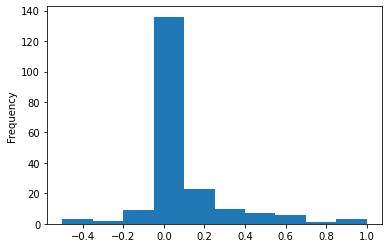

In [163]:
train['sentiment'].plot(kind='hist')

In [164]:
conditions = [
    (train['sentiment'] == 0.0),
    (train['sentiment'] <= -0.1),
    (train['sentiment'] >= -0.1)]
   
values = ['Netural', 'Negative', 'Positive']

train['results'] = np.select(conditions, values)
train.head()

,words,word_count,char_count,avg_word,stopwords,hastags,numerics,upper,sentiment,results
0,hear issue best assistance let marketplace com...,16,103,5.500000,0,0,0,0,1.000000,Positive
1,understand tiring situation however able check...,21,160,6.666667,0,0,0,0,0.408333,Positive
2,get concern contact support using link shared ...,16,104,5.562500,0,0,0,0,0.000000,Netural
3,yaşadığın tatsız için üzgünüm konuyla ilgilene...,27,224,7.333333,0,0,0,0,0.000000,Netural
4,received incorrect product report support chec...,11,79,6.272727,0,0,0,0,0.000000,Netural


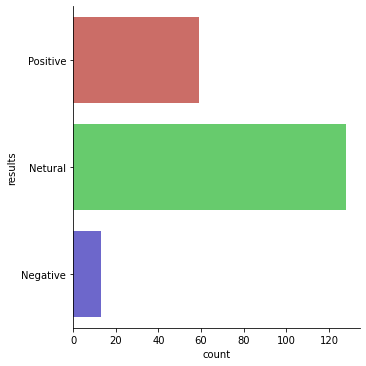

In [165]:
ax = sns.catplot(y="results", data=train,kind="count", palette="hls")

In [166]:
train.to_csv (r'C:\Users\Naeemah\Desktop\emotions_data.csv', index = False, header=True)

In [167]:
topmodel = helpdeskexplain

In [168]:
from sklearn.feature_extraction.text import CountVectorizer

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(topmodel['english_text']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

In [169]:
from sklearn.decomposition import LatentDirichletAllocation
number_of_topics = 10
model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

In [170]:
model.fit(tf)

LatentDirichletAllocation(random_state=0)

In [171]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [172]:
no_top_words = 6
topwords = display_topics(model, tf_feature_names, no_top_words)

In [173]:
topwords

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,details,23.1,sorry,27.1,order,18.1,order,6.1,team,27.7,please,35.1,know,21.1,know,6.1,please,0.1,please,0.1
1,sorry,0.1,please,0.1,team,2.5,please,6.1,details,1.1,order,0.1,order,9.1,please,5.1,order,0.1,order,0.1
2,please,0.1,order,0.1,please,0.1,details,6.1,please,0.1,details,0.1,please,0.1,sorry,5.1,sorry,0.1,sorry,0.1
3,order,0.1,details,0.1,details,0.1,sorry,0.1,order,0.1,know,0.1,sorry,0.1,team,0.1,team,0.1,team,0.1
4,team,0.1,know,0.1,sorry,0.1,team,0.1,sorry,0.1,team,0.1,details,0.1,details,0.1,details,0.1,details,0.1
5,know,0.1,team,0.1,know,0.1,know,0.1,know,0.1,sorry,0.1,team,0.1,order,0.1,know,0.1,know,0.1


In [174]:
topicwords = pd.DataFrame(topwords)

In [175]:
topwords.to_csv (r'C:\Users\Naeemah\Desktop\topwords_data.csv', index = False, header=True)

In [176]:
topicwords.to_csv (r'C:\Users\Naeemah\Desktop\topicwordsnew_data.csv', index = False, header=True)

In [177]:
topicwords.head()

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,details,23.1,sorry,27.1,order,18.1,order,6.1,team,27.7,please,35.1,know,21.1,know,6.1,please,0.1,please,0.1
1,sorry,0.1,please,0.1,team,2.5,please,6.1,details,1.1,order,0.1,order,9.1,please,5.1,order,0.1,order,0.1
2,please,0.1,order,0.1,please,0.1,details,6.1,please,0.1,details,0.1,please,0.1,sorry,5.1,sorry,0.1,sorry,0.1
3,order,0.1,details,0.1,details,0.1,sorry,0.1,order,0.1,know,0.1,sorry,0.1,team,0.1,team,0.1,team,0.1
4,team,0.1,know,0.1,sorry,0.1,team,0.1,sorry,0.1,team,0.1,details,0.1,details,0.1,details,0.1,details,0.1


In [178]:
df1_transposed = topicwords.T

In [179]:
df1_transposed

,0,1,2,3,4,5
Topic 0 words,details,sorry,please,order,team,know
Topic 0 weights,23.1,0.1,0.1,0.1,0.1,0.1
Topic 1 words,sorry,please,order,details,know,team
Topic 1 weights,27.1,0.1,0.1,0.1,0.1,0.1
Topic 2 words,order,team,please,details,sorry,know
Topic 2 weights,18.1,2.5,0.1,0.1,0.1,0.1
Topic 3 words,order,please,details,sorry,team,know
Topic 3 weights,6.1,6.1,6.1,0.1,0.1,0.1
Topic 4 words,team,details,please,order,sorry,know
Topic 4 weights,27.7,1.1,0.1,0.1,0.1,0.1


In [180]:
df1_transposed.to_csv (r'C:\Users\Naeemah\Desktop\topwordstrans_data.csv', index = False, header=True)